In [ ]:
! pip install scikit-plot

In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Add
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
DATA_PATH = "/kaggle/input/fyp-dataset/ck/ck/"
TOP_EMOTIONS = ["Angry", "Fear", "Happy", "Sadness", "Surprise"]

TRAIN_SIZE = 0.80
INPUT_SHAPE = (64,64,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [ ]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

Surprise has 249 number of images
Fear has 75 number of images
Angry has 135 number of images
Sadness has 84 number of images
Happy has 207 number of images

total images are 750


In [ ]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Resize the image to 64x64
            img_arr.append(np.expand_dims(img, axis=2))
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

img_arr.shape, img_label.shape, label_to_text

loaded Surprise images to numpy arrays...
loaded Fear images to numpy arrays...
loaded Angry images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((750, 64, 64, 1),
 (750, 5),
 {0: 'Surprise', 1: 'Fear', 2: 'Angry', 3: 'Sadness', 4: 'Happy'})

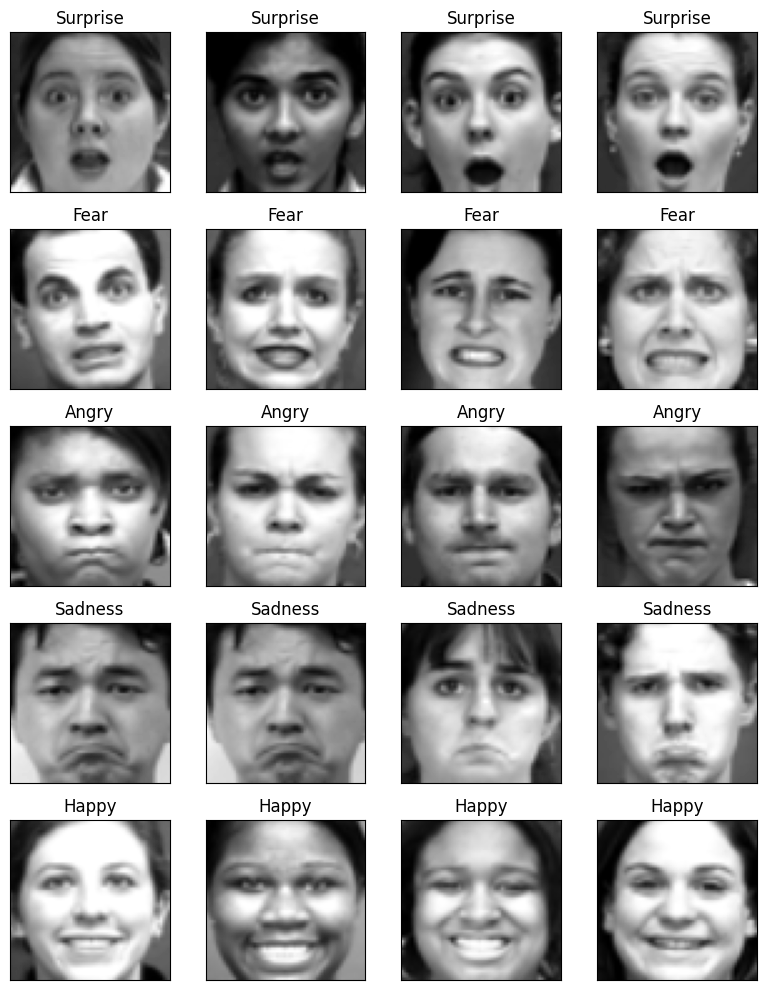

In [ ]:
num_emotions = len(TOP_EMOTIONS)
num_cols = 4
fig, axes = pyplot.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        ax.imshow(img.reshape(64, 64), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])

    idx += 1

pyplot.tight_layout()
pyplot.show()

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((600, 64, 64, 1), (150, 64, 64, 1), (600, 5), (150, 5))

In [ ]:
def identity_block(X, kernel: tuple, filters: list, stage: int, block_id: str):
    conv_name = 'idblock_conv_' +  str(stage) + f'_{block_id}'
    bn_name = 'idblock_bn_' + str(stage) + f'_{block_id}'
    actv_name = "idblock_actv_" + str(stage) + f'_{block_id}'

    X_shortcut = X

    X = Conv2D(
        filters = filters[0],
        kernel_size = (1, 1),
        strides = (1,1),
        padding = 'valid',
        name = conv_name + '_a',
        kernel_initializer = glorot_uniform(seed=0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_a')(X)
    X = Activation('relu', name = actv_name + '_a')(X)

    X = Conv2D(
        filters = filters[1],
        kernel_size = kernel,
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_b',
        kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_b')(X)
    X = Activation('relu', name = actv_name + '_b')(X)

    X = Conv2D(
        filters = filters[2],
        kernel_size = (1,1),
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_c',
        kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu', name = actv_name + '_c')(X)

    return X

In [ ]:
def convolutional_block(X, kernel: tuple, stride: tuple, filters: list, stage: int, block_id: str):
    conv_name = 'convblock_conv_' + str(stage) + f'_{block_id}'
    bn_name = 'convblock_bn_' + str(stage) + f'_{block_id}'
    actv_name = "convblock_actv_" + str(stage) + f'_{block_id}'

    X_shortcut = X

    X = Conv2D(
        filters[0],
        kernel_size = (1, 1),
        strides = stride,
        name = conv_name + '_a',
        kernel_initializer = glorot_uniform(seed=0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_a')(X)
    X = Activation('relu', name = actv_name + '_a')(X)

    X = Conv2D(
        filters[1],
        kernel_size = kernel,
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_b',
        kernel_initializer=glorot_uniform(seed =0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_b')(X)
    X = Activation('relu', name = actv_name + '_b')(X)

    X = Conv2D(
        filters[2],
        kernel_size = (1,1),
        strides = (1,1),
        padding = 'valid',
        name = conv_name + '_c',
        kernel_initializer=glorot_uniform(seed =0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_c')(X)

    X_shortcut = Conv2D(
        filters[2],
        kernel_size = (1,1),
        strides = stride,
        padding = 'valid',
        name = conv_name + '_sc1',
        kernel_initializer=glorot_uniform(seed =0)
    )(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name + '_sc1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu', name = actv_name + '_c')(X)

    return X

In [ ]:
def CNN_with_SkipConnections(input_shape, classes, show_summary=False):
    model_in = Input(input_shape)

    X = Conv2D(
        filters = 32,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'valid',
        name = 'conv_0_a',
        kernel_initializer = glorot_uniform(seed=0)
    )(model_in)
    X = BatchNormalization(axis = 3, name = 'bn_0_a')(X)
    X = Activation('relu', name="actv_0_a")(X)

    X = Conv2D(
        filters = 64,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'valid',
        name = 'conv_0_b',
        kernel_initializer = glorot_uniform(seed=0)
    )(X)
    X = BatchNormalization(axis = 3, name = 'bn_0_b')(X)
    X = Activation('relu', name="actv_0_b")(X)

    # Block 0
    X = convolutional_block(model_in, (3,3), stride=(1,1), filters = [32, 32, 64], stage=0, block_id='a')
    X = identity_block(X, (3,3), [32, 32, 64], stage=0, block_id='a')

    # Block 1
    X = convolutional_block(X, (3,3), stride=(2,2), filters = [64, 64, 128], stage=1, block_id='a')
    X = identity_block(X, (3,3), [64, 64, 128], stage=1, block_id='a')

    # Block 2
    X = convolutional_block(X, (3,3), stride=(2,2), filters = [128,128,256], stage=2, block_id='a')
    X = identity_block(X, (2,2), [128,128,256], stage=2, block_id='a')

    X = AveragePooling2D()(X)

    X = Flatten()(X)
    X = Dense(
        128,
        kernel_initializer = glorot_uniform(seed=0),
        name = 'dense_1',
    )(X)
    X = BatchNormalization(name = 'bn_3')(X)
    X = Activation('relu', name="actv_3")(X)

    model_out = Dense(classes, activation='softmax', name="out_layer")(X)

    model = Model(inputs = model_in, outputs = model_out, name='CNN_with_SkipConnections')

    if show_summary:
        model.summary()

    return model

In [ ]:
model = CNN_with_SkipConnections(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

Model: "CNN_with_SkipConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 convblock_conv_0_a_a (Conv  (None, 64, 64, 32)           64        ['input_1[0][0]']             
 2D)                                                                                              
                                                                                                  
 convblock_bn_0_a_a (BatchN  (None, 64, 64, 32)           128       ['convblock_conv_0_a_a[0][0]']
 ormalization)                                                                                    
                                                                           

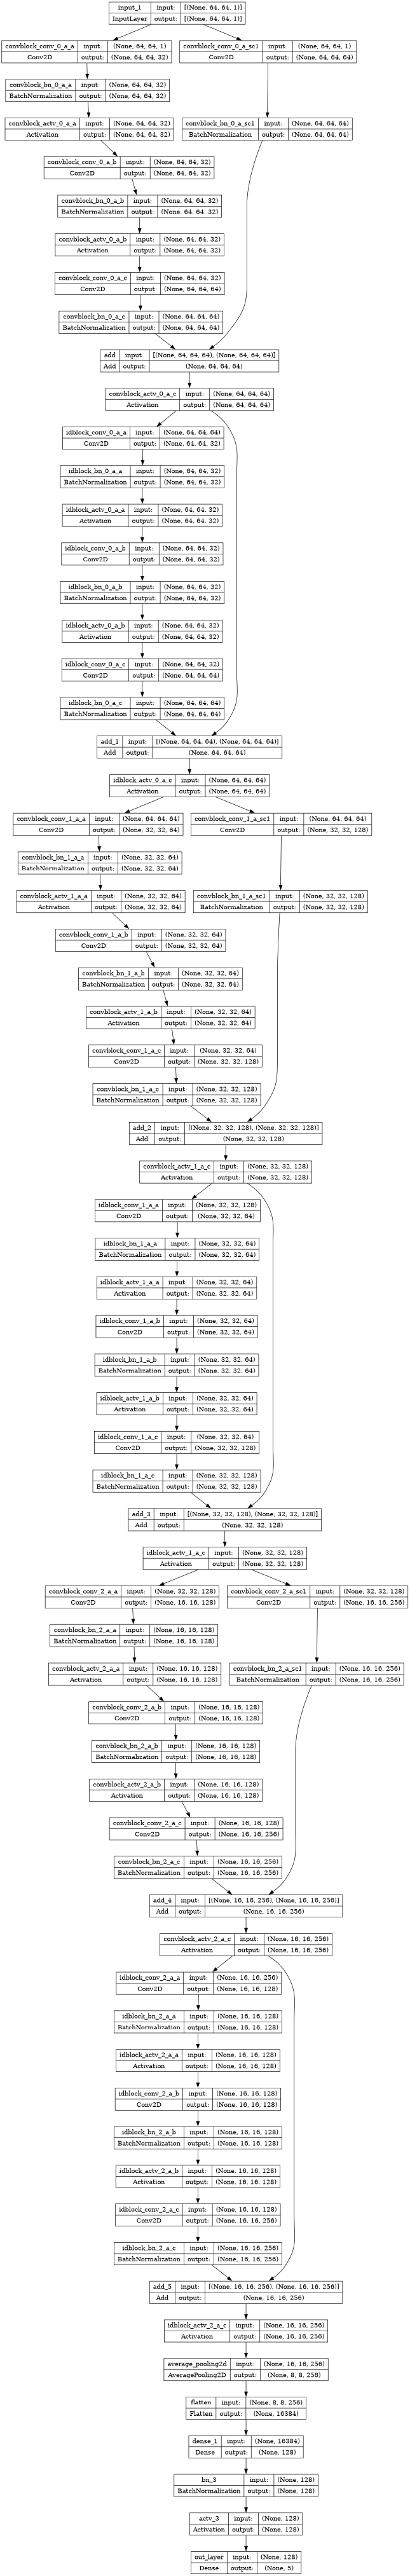

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.2,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=7,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
batch_size = 32
epochs = 100
loss = "categorical_crossentropy"
optim = optimizers.Adam(0.01)

In [ ]:
model.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy']
)

train_datagen.fit(X_train)
history_ResNet = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train) / batch_size,
    epochs = epochs,
    callbacks = [lr_scheduler, early_stopping],
)

Epoch 1/100
18/18 [==============================] - 21s 172ms/step - loss: 1.5292 - accuracy: 0.4967 - val_loss: 9.6524 - val_accuracy: 0.0400 - lr: 0.0100
Epoch 2/100
18/18 [==============================] - 1s 56ms/step - loss: 0.7827 - accuracy: 0.7050 - val_loss: 2.4852 - val_accuracy: 0.2267 - lr: 0.0100
Epoch 3/100
18/18 [==============================] - 1s 54ms/step - loss: 0.5172 - accuracy: 0.7933 - val_loss: 4.4417 - val_accuracy: 0.1933 - lr: 0.0100
Epoch 4/100
18/18 [==============================] - 1s 54ms/step - loss: 0.3845 - accuracy: 0.8550 - val_loss: 4.7078 - val_accuracy: 0.1933 - lr: 0.0100
Epoch 5/100
18/18 [==============================] - 1s 54ms/step - loss: 0.3447 - accuracy: 0.8767 - val_loss: 8.8095 - val_accuracy: 0.1733 - lr: 0.0100
Epoch 6/100
18/18 [==============================] - 1s 56ms/step - loss: 0.3526 - accuracy: 0.8600 - val_loss: 2.2776 - val_accuracy: 0.3933 - lr: 0.0100
Epoch 7/100
18/18 [==============================] - 1s 54ms/step - 

In [ ]:
history = pd.DataFrame(history_ResNet.history)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,1.529171,0.496667,9.652383,0.040000,0.0100
1,0.782745,0.705000,2.485172,0.226667,0.0100
2,0.517204,0.793333,4.441690,0.193333,0.0100
3,0.384451,0.855000,4.707756,0.193333,0.0100
4,0.344717,0.876667,8.809457,0.173333,0.0100
5,0.352574,0.860000,2.277598,0.393333,0.0100
6,0.293420,0.888333,5.624007,0.193333,0.0100
7,0.241519,0.903333,7.202355,0.213333,0.0100
8,0.300847,0.890000,3.103487,0.340000,0.0100
9,0.181472,0.930000,1.381628,0.506667,0.0100


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

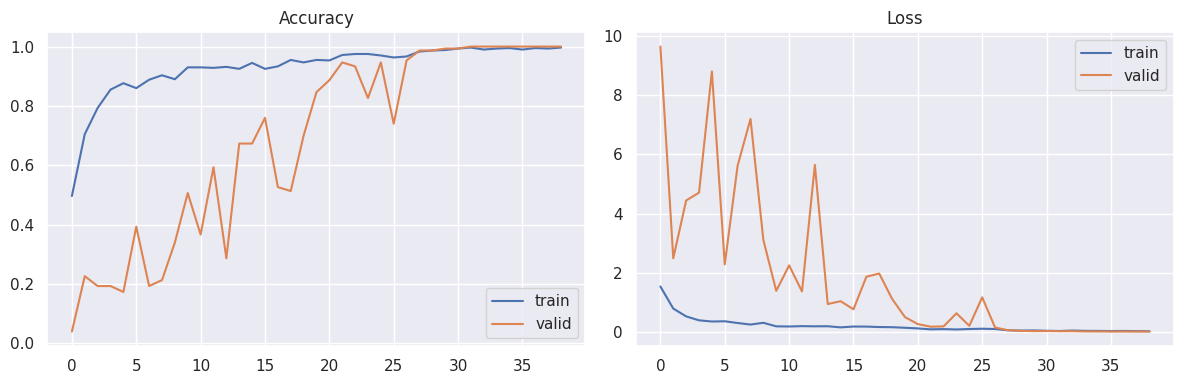

In [ ]:
sns.set()
fig = pyplot.figure(figsize=(12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history_ResNet.epoch, y=history_ResNet.history['accuracy'], label='train')
sns.lineplot(x=history_ResNet.epoch, y=history_ResNet.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history_ResNet.epoch, y=history_ResNet.history['loss'], label='train')
sns.lineplot(x=history_ResNet.epoch, y=history_ResNet.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.show()

In [ ]:
label_to_text

{0: 'Surprise', 1: 'Fear', 2: 'Angry', 3: 'Sadness', 4: 'Happy'}

19/19 - 0s - loss: 0.0040 - accuracy: 1.0000 - 262ms/epoch - 14ms/step

train Accuracy: 1.0
5/5 - 0s - loss: 0.0165 - accuracy: 1.0000 - 79ms/epoch - 16ms/step

Test Accuracy: 1.0
5/5 [==============================] - 0s 11ms/step

Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        50
        Fear       1.00      1.00      1.00        15
       Happy       1.00      1.00      1.00        27
     Sadness       1.00      1.00      1.00        17
    Surprise       1.00      1.00      1.00        41

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



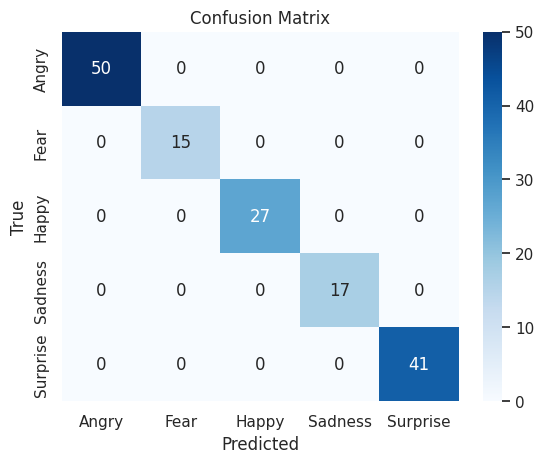

In [ ]:
from sklearn.metrics import confusion_matrix

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=TOP_EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TOP_EMOTIONS, yticklabels=TOP_EMOTIONS)
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.show()

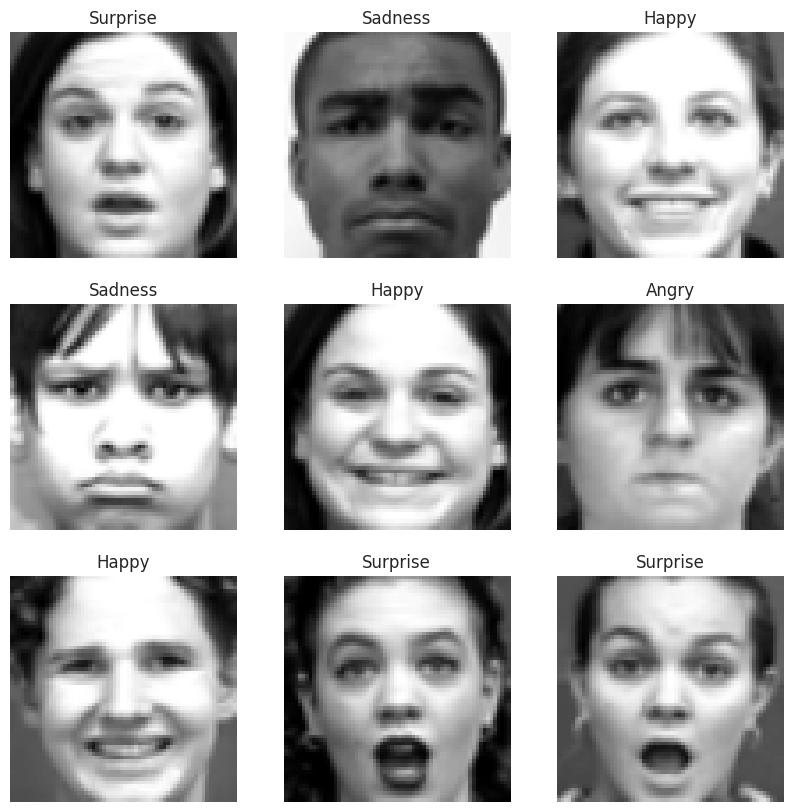

In [ ]:
# Visualize some predictions
pyplot.figure(figsize=(10, 10))
for i in range(9):
    ax = pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(X_test[i].reshape(64, 64), cmap='gray')
    pyplot.title(label_to_text[predicted_labels[i]])
    pyplot.axis("off")

pyplot.show()

In [ ]:
pip install visualkeras

  Obtaining dependency information for visualkeras from https://files.pythonhosted.org/packages/a5/93/abd375b37add77d58a8c48a506ae39bb77c4380e2507ea444325ff1b9971/visualkeras-0.0.2-py3-none-any.whl.metadata
  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/e4/57/59b42e145ff12941c5c63d59dc48369912a9e29d69966ff630e6f0f815ac/aggdraw-1.3.18.post0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 12.9 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


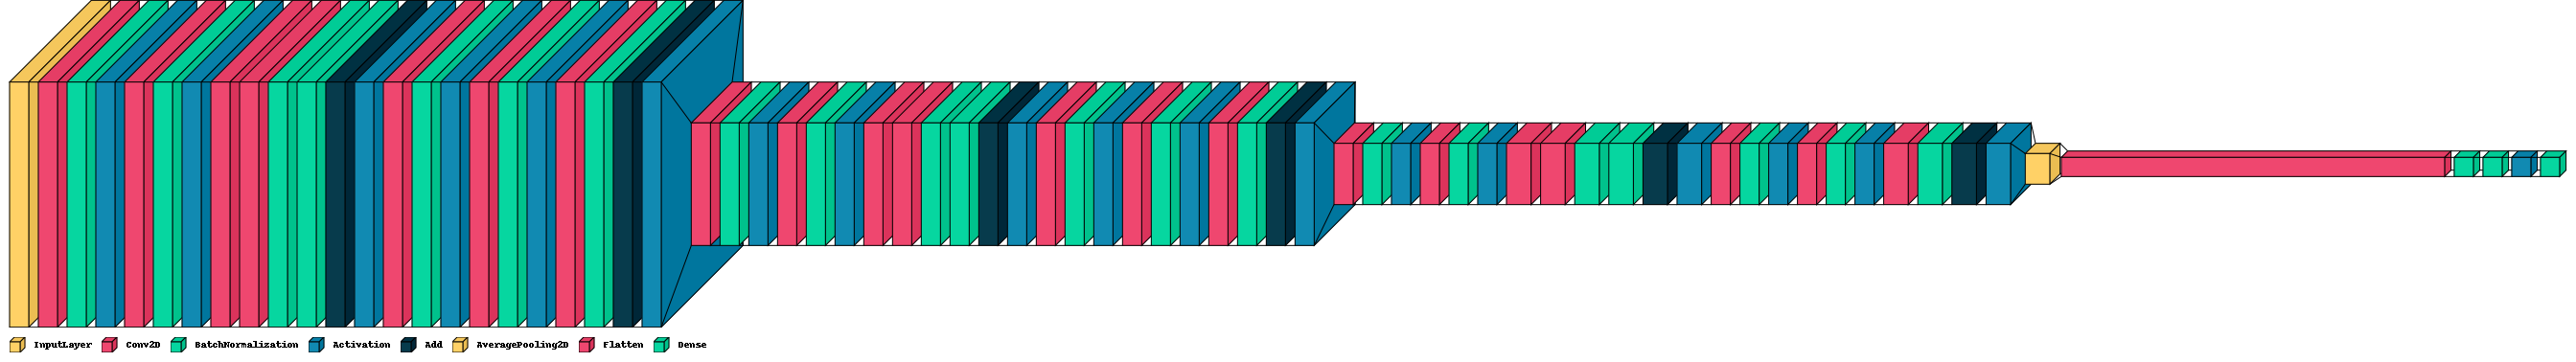

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True)